In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def normalize_ingreds(x: list[str]) -> str:
    skip_verbs = [
        "crushed","crumbles","ground","minced","powder","chopped",
        "sliced","grilled","boneless","skinless","steamed"]
    remove_verbs = lambda x: re.sub(r"|".join(skip_verbs),'', x)
    ingreds = list(map(remove_verbs, x))

    lemmatizer = WordNetLemmatizer()
    ingreds = [" ".join([lemmatizer.lemmatize(j) 
                    for j in i.lower().split(" ")]) 
                for i in ingreds]
    
    ingreds = [re.sub("[^A-Za-z ]", "", i) for i in ingreds]
    ingreds = [re.sub(" +", " ", i) for i in ingreds]
    ingreds = [i.strip().replace(" ", "_" ) for i in ingreds]

    return ",".join(ingreds)

In [19]:
yummly_df = pd.read_json("../assets/yummly.json")
yummly_df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [3]:
yummly_df["ingredients"] = yummly_df["ingredients"].map(normalize_ingreds)
yummly_df = yummly_df[~yummly_df.duplicated(["cuisine", "ingredients"], keep="first")]
yummly_df

,id,cuisine,ingredients
0,10259,greek,"romaine_lettuce,black_olive,grape_tomato,garli..."
1,25693,southern_us,"plain_flour,pepper,salt,tomato,black_pepper,th..."
2,20130,filipino,"egg,pepper,salt,mayonaise,cooking_oil,green_ch..."
3,22213,indian,"water,vegetable_oil,wheat,salt"
4,13162,indian,"black_pepper,shallot,cornflour,cayenne_pepper,..."
...,...,...,...
39769,29109,irish,"light_brown_sugar,granulated_sugar,butter,warm..."
39770,11462,italian,"kraft_zesty_italian_dressing,purple_onion,broc..."
39771,2238,irish,"egg,citrus_fruit,raisin,sourdough_starter,flou..."
39772,41882,chinese,"chicken_thigh,garlic,white_rice,baking,corn_st..."


## Cusine Prediction using Linear SVC

In [4]:
y = yummly_df["cuisine"]
X = yummly_df.drop(["cuisine"], axis=1)

le = LabelEncoder()
y_transformed = le.fit_transform(yummly_df["cuisine"])

X_train, X_test , y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2)

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('vectorizer', TfidfVectorizer(
            ngram_range=(1,1), stop_words="english"), "ingredients")
    ])

clf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', CalibratedClassifierCV(LinearSVC(C=0.9, penalty='l2')))
])

cross_val_score(clf_pipe, X, y_transformed, cv=5)

array([0.78540827, 0.7936988 , 0.78802773, 0.78676749, 0.7936988 ])

In [6]:
clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.46      0.59       104
           1       0.60      0.48      0.53       147
           2       0.78      0.72      0.75       293
           3       0.79      0.86      0.82       541
           4       0.67      0.66      0.67       150
           5       0.61      0.66      0.63       525
           6       0.78      0.72      0.75       251
           7       0.88      0.93      0.90       623
           8       0.75      0.46      0.57       155
           9       0.80      0.89      0.84      1557
          10       0.80      0.67      0.73        97
          11       0.84      0.72      0.78       278
          12       0.85      0.79      0.82       169
          13       0.90      0.92      0.91      1269
          14       0.80      0.79      0.80       155
          15       0.71      0.47      0.57        99
          16       0.72      0.77      0.74       834
   

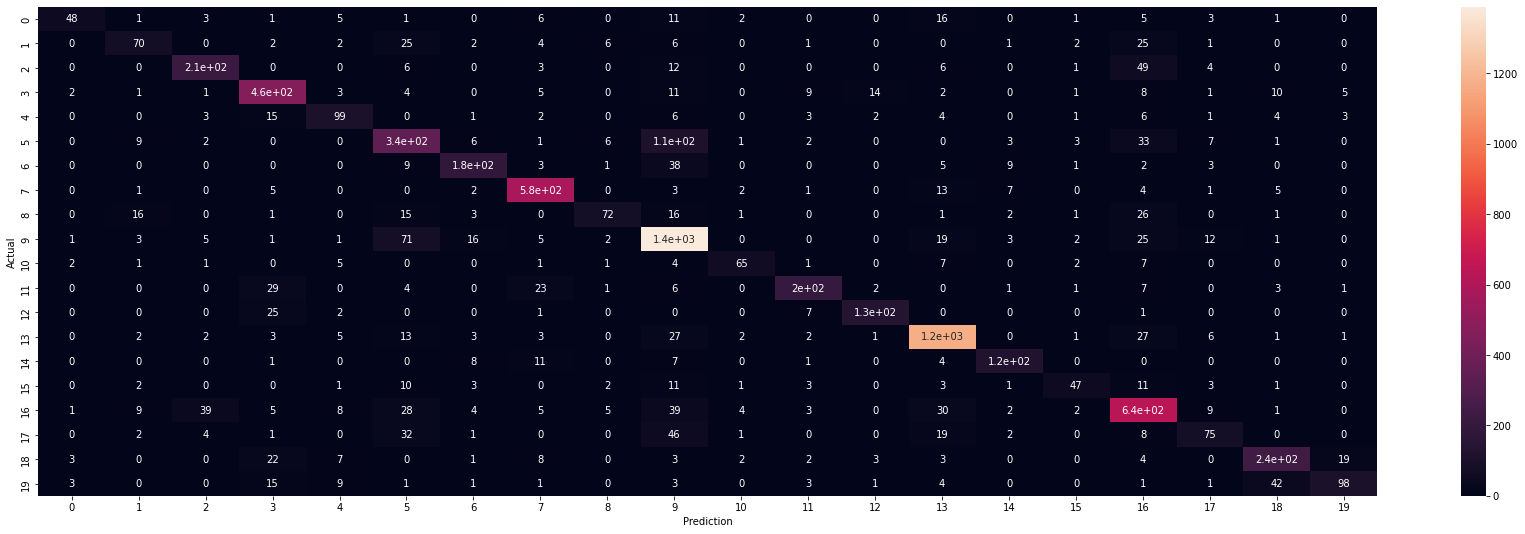

In [7]:
plt.figure(figsize=(30, 9))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Similar dish prediction using K-Nearest Neighbors Algorithm

In [8]:
y = yummly_df["cuisine"]
X = yummly_df.drop(["cuisine"], axis=1)

le = LabelEncoder()
y_transformed = le.fit_transform(yummly_df["cuisine"])

X_train, X_test , y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2)

In [9]:
vec = TfidfVectorizer(ngram_range=(1,1), stop_words="english")
X_transformed = vec.fit_transform(X["ingredients"])

X_train2, X_test2 , y_train2, y_test2 = train_test_split(
    X_transformed, y_transformed, test_size=0.2)

error_rate = []

# Will take some time
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train2,y_train2)
    pred_i = knn.predict(X_test2)
    error_rate.append(np.mean(pred_i != y_test2))

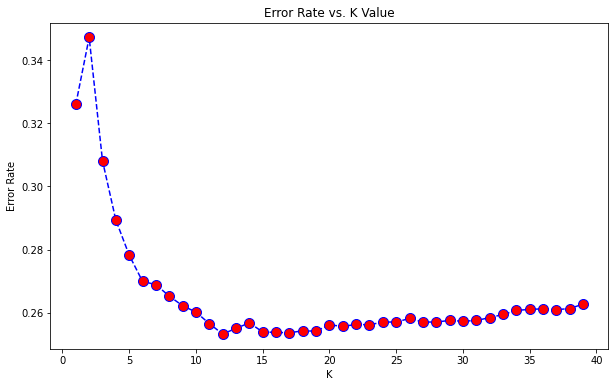

In [10]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1,40),
    error_rate,
    color="blue", 
    linestyle="dashed", 
    marker="o",
    markerfacecolor="red", 
    markersize=10)
plt.title("Error Rate vs. K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.show()

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('vectorizer', TfidfVectorizer(
            ngram_range=(1,1), stop_words="english"), "ingredients")
    ])

knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', KNeighborsClassifier(n_neighbors=14, metric="cosine"))
])

cross_val_score(knn_pipe, X, y_transformed, cv=5)

array([0.74584173, 0.74757404, 0.74240706, 0.74039067, 0.7463138 ])

In [12]:
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.53        93
           1       0.54      0.31      0.39       154
           2       0.74      0.61      0.67       310
           3       0.74      0.87      0.80       548
           4       0.68      0.56      0.61       138
           5       0.55      0.61      0.58       528
           6       0.77      0.61      0.68       230
           7       0.86      0.87      0.87       643
           8       0.64      0.44      0.52       128
           9       0.73      0.88      0.80      1568
          10       0.80      0.57      0.67        93
          11       0.80      0.66      0.72       271
          12       0.79      0.68      0.73       177
          13       0.84      0.89      0.86      1284
          14       0.80      0.65      0.72       178
          15       0.65      0.31      0.42        99
          16       0.68      0.78      0.72       799
   

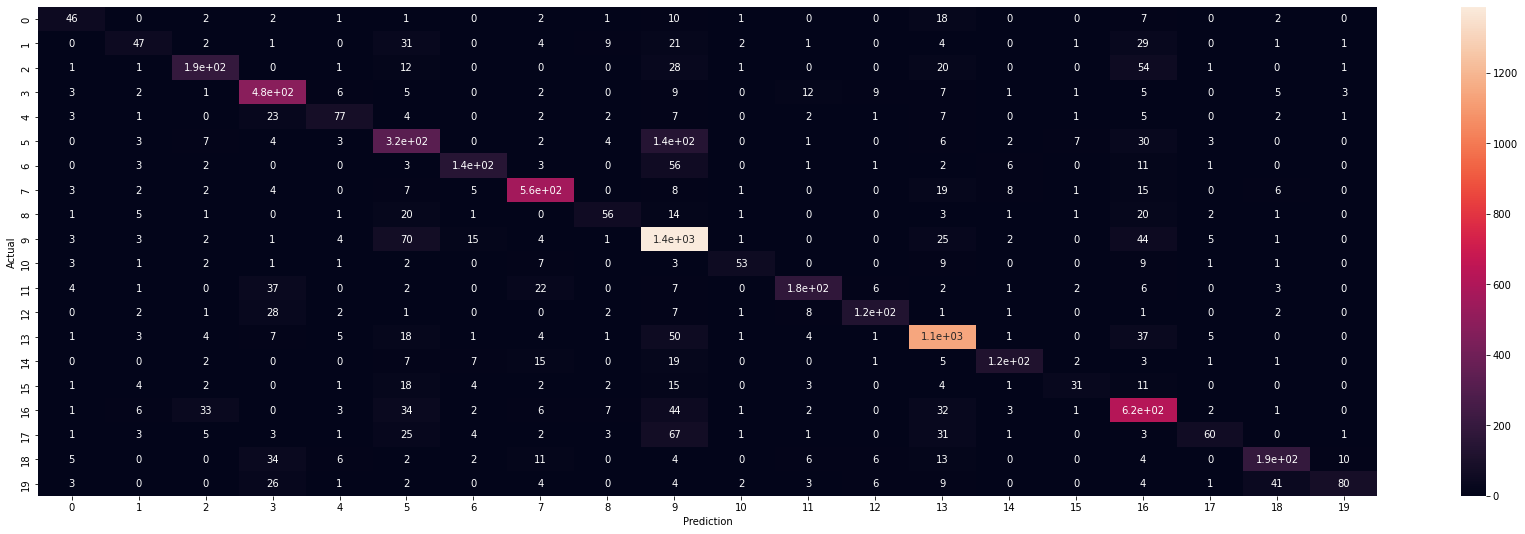

In [13]:
plt.figure(figsize=(30, 9))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# CLI Use-Case

#### Predicting cusine using LinearSVC

In [14]:
input_ingreds = [
    "chili powder",
    "crushed red pepper flakes",
    "sea salt",
    "ground cumin",
    "onion powder",
    "dried oregano",
    "ground black pepper",
    "paprika"
]

input_df = pd.DataFrame([normalize_ingreds(input_ingreds)], columns=["ingredients"])
input_df


,ingredients
0,"chili,red_pepper_flake,sea_salt,cumin,onion,dr..."


In [15]:
sorted(
    [(c, s) for c, s in zip(le.classes_, clf_pipe.predict_proba(input_df)[0])],
    key=lambda x: x[1],
    reverse=True
)[0]

('mexican', 0.8716092890547706)

#### Predicting K-nearest neighbors based on inputs using KNN

In [16]:
inp_vec = knn_pipe[0].transform(input_df)
dist, neighbors = knn_pipe[-1].kneighbors(X=inp_vec, n_neighbors=6)

In [17]:
similars = [(n, 1 - d) for n,d in zip(neighbors[0], dist[0])]
similars # (row_id in fitted data, Cosine Similarity score)

[(1114, 0.9780681816563327),
 (28171, 0.9780681816563327),
 (9229, 0.915851148275046),
 (23688, 0.7866653425785131),
 (18702, 0.7581027506834342),
 (5603, 0.693082909889446)]

In [18]:
# (Dish ID, Cosine Similarity score)
list((X_train.iat[row_id, 0], score) for row_id, score in similars)

[(37038, 0.9780681816563327),
 (10276, 0.9780681816563327),
 (13296, 0.915851148275046),
 (13746, 0.7866653425785131),
 (37316, 0.7581027506834342),
 (2298, 0.693082909889446)]